# 6 Visualise laballed data and remove artefacts

Code that let us overlay each frame of video with outputs from the models. And create time series plots. 

In [1]:
import os
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import ultralytics.utils as ultrautils
import utils
import display

In [2]:
videos_in = r"..\LookitLaughter.test"
metadata_file = "_LookitLaughter.xlsx"
data_out = r"..\data\1_interim"
videos_out = r"..\data\2_final"

#a couple of files for testing
VIDEO_FILE  = os.path.join(videos_in, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")
VIDEO_FILE2 = os.path.join(videos_in, "2UWdXP.joke2.rep1.take1.NomNomNom.mp4")

testset = [VIDEO_FILE, VIDEO_FILE2] 

In [3]:
processedvideos = utils.getprocessedvideos(data_out)
processedvideos.head()

Found existing processedvideos.xlsx


,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Audio.file,Faces.when,Faces.file,LastError,Speech.file,Speech.when,Objects.file,Objects.when,Understand.file,Understand.when
0,2UWdXP.joke1.rep2.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,217,14.298910,...,..\data\1_interim\\2UWdXP.joke1.rep2.take1.Pee...,2023-10-04 11:31:32,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,2023-09-20 16:58:38,NaN,NaN,NaN,NaN
1,2UWdXP.joke1.rep3.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,152,14.359089,...,..\data\1_interim\\2UWdXP.joke1.rep3.take1.Pee...,2023-10-04 11:33:44,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,2023-09-20 16:58:39,NaN,NaN,NaN,NaN
2,2UWdXP.joke2.rep1.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,95,13.241315,...,..\data\1_interim\\2UWdXP.joke2.rep1.take1.Nom...,2023-10-04 11:35:09,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
3,2UWdXP.joke2.rep2.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,97,14.213813,...,..\data\1_interim\\2UWdXP.joke2.rep2.take1.Nom...,2023-10-04 11:36:15,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
4,2UWdXP.joke2.rep3.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,133,14.223092,...,..\data\1_interim\\2UWdXP.joke2.rep3.take1.Nom...,2023-10-04 11:38:34,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,2023-09-20 16:58:48,NaN,NaN,NaN,NaN


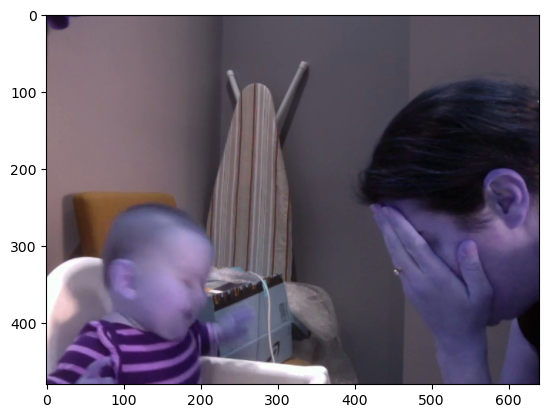

We have a keypoints file for this video


In [4]:
#let's grab a single frame from the video

framenum = 100
video = cv2.VideoCapture(VIDEO_FILE)
video.set(cv2.CAP_PROP_POS_FRAMES, framenum)
ret, frame = video.read()

if ret:
    plt.imshow(frame)
    plt.show()

#look in processed videos to see if we have a keypoints file for this video
videoname = os.path.basename(VIDEO_FILE)
videodata = processedvideos[processedvideos['VideoID'] == videoname]
if videodata.shape[0] > 0:
    print("We have a keypoints file for this video")
    kptsfile = videodata['Keypoints.file'].values[0]
    #Load the keypoints file
    kpts = pd.read_csv(kptsfile)
    kpts.head()

video.release()

In [5]:
print(f"kptsfile: {kptsfile}")

kpts.iloc[3]

kptsfile: ..\data\1_interim\2UWdXP.joke1.rep2.take1.Peekaboo.csv


Unnamed: 0                   3
frame                        3
person                   child
index                        0
bboxcent.x            517.6922
bboxcent.y          268.861542
bbox.width          244.291595
bbox.height         422.276947
bbox.c                0.519463
nose.x              451.206238
nose.y              312.775391
nose.c                0.950903
left_eye.x          467.204437
left_eye.y          267.338623
left_eye.c            0.988065
right_eye.x         454.171204
right_eye.y         275.966919
right_eye.c            0.23554
left_ear.x          572.157776
left_ear.y          238.928513
left_ear.c            0.967395
right_ear.x         519.890564
right_ear.y         258.796753
right_ear.c           0.002977
left_shoulder.x     583.715942
left_shoulder.y     429.665161
left_shoulder.c       0.451757
right_shoulder.x    599.972229
right_shoulder.y    384.976929
right_shoulder.c      0.284799
left_elbow.x        433.458069
left_elbow.y             480.0
left_elb

In [6]:
framekpts = kpts[kpts['frame'] == 100]

nrows = framekpts.shape[0]
bboxlabels = [None] * nrows
#for each row framekpts, create a label for the bounding box from person and index cols
for idx in range(nrows):
    pers = framekpts["person"].values[idx]
    index = framekpts["index"].values[idx]
    bboxlabels[idx] =  f'{pers}: {index}'
    
bboxes = framekpts.iloc[:,4:8].values
bboxes = ultrautils.ops.xywh2xyxy(bboxes)

xycs = framekpts.iloc[:,9:].values

print(bboxlabels)
print(bboxes)
print(xycs)

['child: 0', 'adult: 1']
[[     413.88      74.948      639.83         480]
 [    0.67584      246.46      314.68         480]]
[[     500.89      347.01     0.52779      490.22      306.72     0.71149      502.47      323.54    0.022459      562.61      249.08     0.74954      580.61      294.63   0.0017945         640      397.04     0.20739         640      383.86     0.19471      628.18         480    0.024444      600.86      466.08
     0.056087      543.05      419.03     0.18676      537.86       430.9     0.30838      634.39         480  0.00073335         640      456.83   0.0014618      595.61      384.04   0.0031496      639.96      335.55   0.0082733      531.86      435.85   0.0032835      519.38      381.44   0.0078899]
 [     203.38      364.81     0.98399      204.03      347.89     0.66692      184.26      346.22     0.99364      184.97      348.66   0.0019566      106.19      343.49     0.98222      160.59      392.92     0.88341      37.974      410.06     0.70744  

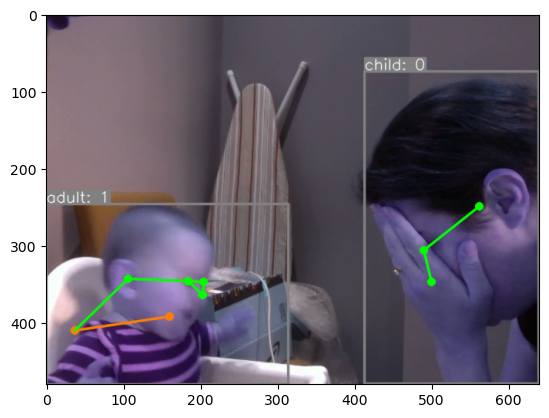

In [7]:
frame = display.drawOneFrame(frame, bboxlabels, bboxes, xycs)

plt.imshow(frame)
plt.show()


In [8]:
def createAnnotatedVideo(videopath,kptsdf = None,facesdf = None,speechdf = None, videos_out = None):
    '''
    Take a processed video and go through frame by frame, adding the bounding boxes, keypoints, face/emotion and speech info.
    Then export the resulting video to a file.
    args:   
        videopath: path to the video file
        kptsdf: dataframe of the keypoints
        facesdf: dataframe of the faces
        speechdf: dataframe of the speech
        videos_out: path to the output directory
    returns:
        None
    '''
    video = cv2.VideoCapture(videopath)
    fps = video.get(cv2.CAP_PROP_FPS)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    #loop through frames annotating each one and storing to a list
    annotatedframes = []
    framenum = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        #get the keypoints for this frame
        if kptsdf is None:
            bboxes = None
            xycs = None
        else:
            framekpts = kptsdf[kptsdf['frame'] == framenum]
            nrows = framekpts.shape[0]
            bboxlabels = [None] * nrows
            #for each row framekpts, create a label for the bounding box from person and index cols
            for idx in range(nrows):
                pers = framekpts["person"].values[idx]
                index = framekpts["index"].values[idx]
                bboxlabels[idx] =  f'{pers}: {index}'
                
            bboxes = framekpts.iloc[:,4:8].values
            bboxes = ultrautils.ops.xywh2xyxy(bboxes) #need to convert the bounding box to xyxy format

            xycs = framekpts.iloc[:,9:].values
            frame = display.drawOneFrame(frame, bboxlabels, bboxes, xycs)
        if facesdf is None:
            framefaces = None
        else:
            #get the faces for this frame
            framefaces = facesdf[facesdf['frame'] == framenum]
            facelabels = framefaces['emotion'].values
            #TODO - maybe include age & gender info
            faceboxes = framefaces.iloc[:,4:8].values
            #faceboxes = ultrautils.ops.xywh2xyxy(faceboxes)
            frame = display.drawOneFrame(frame, facelabels, faceboxes)
        #TODO
        # #get the speech for this frame
        #framespeech = speechdf[speechdf['frame'] == framenum]
        ##draw the frame
        #frame = display.drawOneFrame(frame, framekpts, framefaces, framespeech)
        
        #add the frame to the list
        annotatedframes.append(frame)
        framenum += 1

    #release the video
    video.release()

    #create the output video
    if videos_out is None:
        videos_out = os.path.dirname(videopath)
    videoname = os.path.basename(videopath)
    videofilename = os.path.splitext(videoname)[0] + "_annotated.mp4"
    outpath = os.path.join(videos_out, videofilename)
    out  = cv2.VideoWriter(outpath, fourcc, fps, (width, height))
    print(f"Writing video to {outpath}")

        
    for i in range(len(annotatedframes)):
        out.write(annotatedframes[i])
    out.release()

    



In [9]:
#look in processed videos to see if we have a keypoints file for this video
videoname = os.path.basename(VIDEO_FILE)
videodata = processedvideos[processedvideos['VideoID'] == videoname]
if videodata.shape[0] > 0:
    kptsfile = videodata['Keypoints.file'].values[0]
    if os.path.exists(kptsfile):
        print(f"Keypoints found: {kptsfile}")
        kpts = pd.read_csv(kptsfile)
    facesfile = videodata['Faces.file'].values[0]
    if os.path.exists(kptsfile):
        print(f"Face data found: {facesfile}")
        facedata = pd.read_csv(facesfile)
    

createAnnotatedVideo(VIDEO_FILE, kpts, facedata, None, videos_out)



Keypoints found: ..\data\1_interim\2UWdXP.joke1.rep2.take1.Peekaboo.csv
Face data found: ..\data\1_interim\2UWdXP.joke1.rep2.take1.Peekaboo.faces.ssd.csv
Writing video to ..\data\2_final\2UWdXP.joke1.rep2.take1.Peekaboo_annotated.mp4


In [8]:



bbox1 = kpts.iloc[3,4:8].values
xyxy = ultrautils.ops.xywh2xyxy(bbox1)

print(xyxy)

[395.54640197753906 57.72306823730469 639.8379974365234 480.00001525878906]


In [18]:
framefaces = facedata[facedata['frame'] == 10]
faceboxes = framefaces.iloc[:,4:8].values
print(faceboxes)
xyxy = ultrautils.ops.xywh2xyxy(faceboxes)
print(xyxy)

[[435 166 155 205]]
[[357  63 512 268]]
